## Wykrywanie anomalii w rzeczywistych zbiorach 

    Zadanie wyjaśnimy na podstawie zbioru danych SMTP - zawierającego anomalie (ataki) SMTP.
    
    Ten zbiór i inne rzeczywiste zbiory danych do wykorzystania w I części laboratorium pobieramy z: 
    http://odds.cs.stonybrook.edu/
    

### SMTP dataset

http://odds.cs.stonybrook.edu/smtp-kddcup99-dataset/

Smtp (KDDCUP99)	\
points:      95156	\
dimenstions: 3	\
outliers:     30 (0.03%)

Zbiór zawiera wybrane (zagregowane) cechy połączeń TCP, spośród których 30 (oznaczone jako outliers) to próby ataku, pozostałe - normalny ruch (inliers).

Zadanie polega na zbadaniu skuteczności różnych metod wykrywania anomalii do detekcji tych ataków.  


In [ ]:
!pip install h5py
!pip install tables

In [3]:
import h5py
import numpy as np

f = h5py.File('../datasets/smtp.mat', 'r')
print(f.keys())

y1 = np.array(f.get('y'))
x1 = np.array(f.get('X')).T
y1_ = np.array(f.get('y')).ravel().astype(dtype=np.uint8)

<KeysViewHDF5 ['X', 'y']>


In [4]:
import scipy.io
import pandas as pd

mat = scipy.io.loadmat('../datasets/pima.mat')
print(mat.keys())

x = np.array(mat.get('X'))
y = np.array(mat.get('y')).ravel().astype(dtype=np.uint8)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


# Data description

X zawiera obserwacje (wiersze) - cechy połączeń
y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)


In [5]:
x_df = pd.DataFrame(x)
y_df = pd.DataFrame(y)

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_ood, y_ood = x[y == 1], y[y == 1]

### X description

                0           1           2           3           4           5  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

                6           7  
count  768.000000  768.000000  
mean     0.471876   33.240885  
std      0.331329   11.760232  
min      0.078000   21.000000  
25%      0.243750   24.000000  
50%      0.372500   29.000000  
75%      0.626250   41.000000  
max      2.420

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: >]], dtype=object)

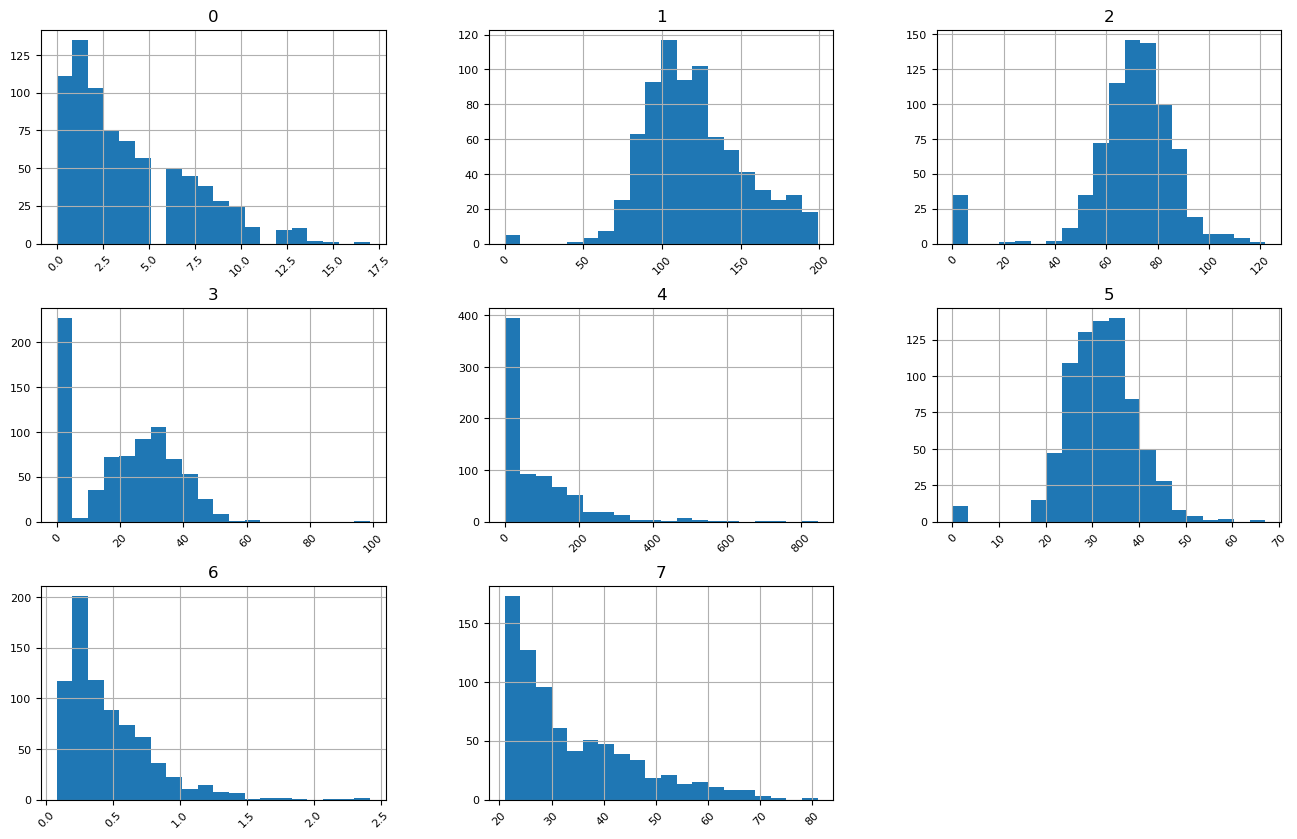

In [7]:
print(x_df.describe())

x_df.hist(figsize=(16,10), bins=20, xlabelsize=8, ylabelsize=8, xrot=45)

In [8]:
print(x_df.head())

     0      1     2     3      4     5      6     7
0  6.0  148.0  72.0  35.0    0.0  33.6  0.627  50.0
1  1.0   85.0  66.0  29.0    0.0  26.6  0.351  31.0
2  8.0  183.0  64.0   0.0    0.0  23.3  0.672  32.0
3  1.0   89.0  66.0  23.0   94.0  28.1  0.167  21.0
4  0.0  137.0  40.0  35.0  168.0  43.1  2.288  33.0


### Y description

                0
count  768.000000
mean     0.348958
std      0.476951
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

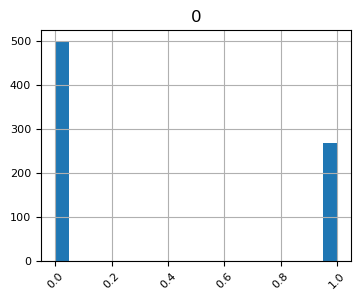

In [9]:
print(y_df.describe())

y_df.hist(figsize=(4,3), bins=20, xlabelsize=8, ylabelsize=8, xrot=45)

In [10]:
print(y_df.head())

   0
0  1
1  0
2  1
3  0
4  1


## LOF

In [11]:
from sklearn.neighbors import LocalOutlierFactor

# model = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination='auto')
model = LocalOutlierFactor(n_neighbors=1, novelty=False, contamination='auto')

y_pred = model.fit_predict(x)  # 1 - inlier, -1 - outlier

In [12]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [13]:
print("\nTrue labels:")
print(np.array(np.unique(y, return_counts=True)))

print("\nPredicted labels:")
print(np.array(np.unique(y_pred, return_counts=True)))


True labels:
[[  0   1]
 [500 268]]

Predicted labels:
[[  0   1]
 [651 117]]


In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[423,  77],
       [228,  40]], dtype=int64)

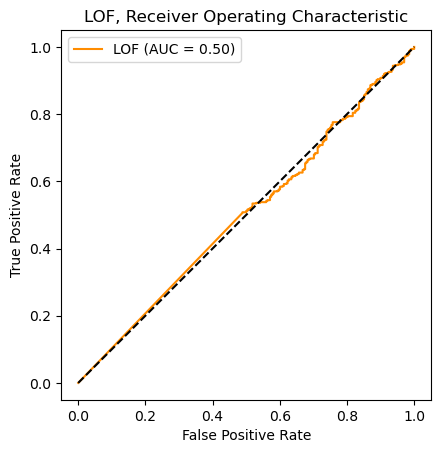

In [15]:
### plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(x)
y_pred = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()


-1.0863721781996936
-1.0961847173245491
-1.101922206643166


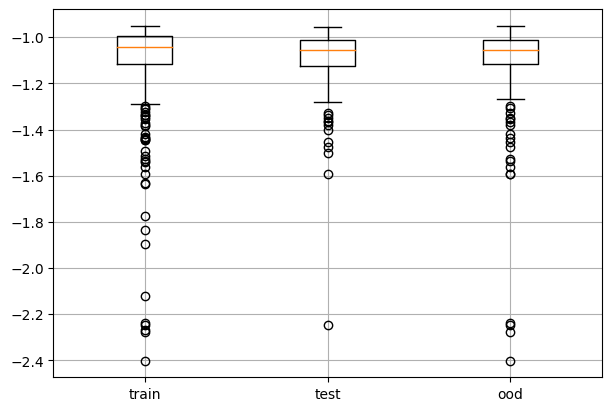

In [16]:
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(x_train)

train_scores = model.score_samples(x_train)
test_scores = model.score_samples(x_test)
ood_scores = model.score_samples(x_ood)

if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()

## Isolation Forest

In [204]:
from sklearn.ensemble import IsolationForest


model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

y_pred = model.fit_predict(x)  # 1 - inlier, -1 - outlier

In [205]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [206]:

print("\nTrue labels:")
print(np.array(np.unique(y, return_counts=True)))

print("\nPredicted labels:")
print(np.array(np.unique(y_pred, return_counts=True)))


True labels:
[[  0   1]
 [500 268]]

Predicted labels:
[[  0   1]
 [691  77]]


In [207]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[470,  30],
       [221,  47]], dtype=int64)

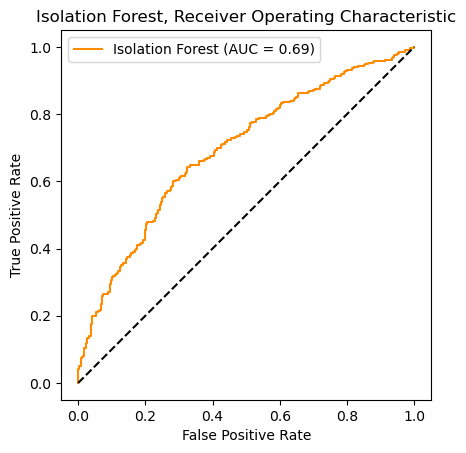

In [208]:

### plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(x)
y_pred = model.decision_function(x)


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="Isolation Forest",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Isolation Forest, Receiver Operating Characteristic")
plt.legend()
plt.show()


-0.4458555818716769
-0.45492345319435584
-0.4663743969240286


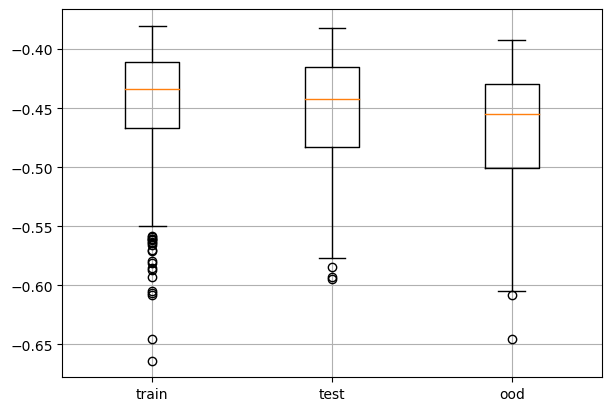

In [209]:
train_scores = model.score_samples(x_train)
test_scores = model.score_samples(x_test)
ood_scores = model.score_samples(x_ood)

if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()

## IRW - Integrated Rank-Weighted depth

fitted IRWdepth model with 1000 projections in 614 dimensions
--- 19.195000410079956 seconds ---
0.2500016286644951
0.2382274525149118


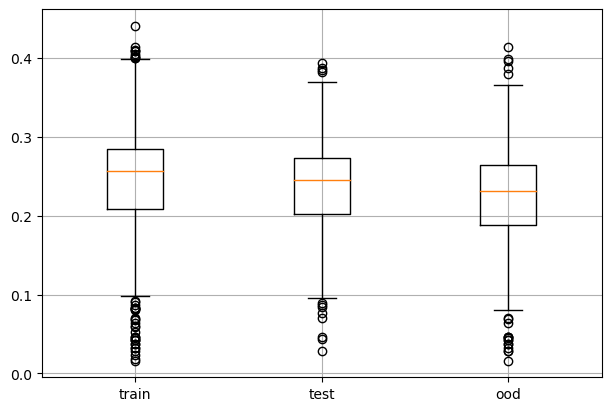

In [210]:
import time
from IRW_score import IRWdepth

model = IRWdepth()
nproj = 1000
model.fit(x_train, nproj)

start_time = time.time()

train_scores = [model.score(row) for row in x_train]
test_scores = [model.score(row) for row in x_test]
ood_scores = [model.score(row) for row in x_ood]

print("--- %s seconds ---" % (time.time() - start_time))


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()

## Parametric model - assume MVN data
    outlierness score - based on Mahalanobis distance

-15.598664301602765
-18.101632063080366
-21.08832831728192


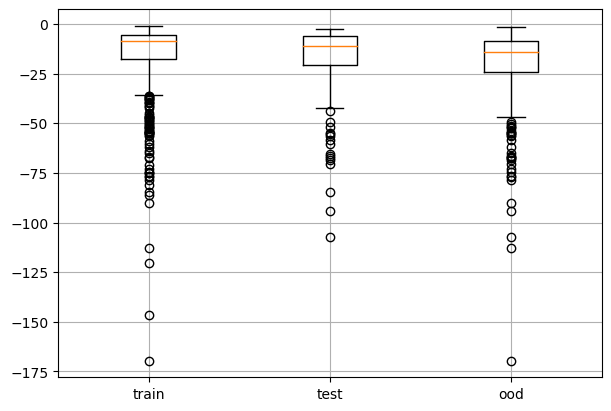

In [212]:
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=0.01, random_state=42)

model.fit(x_train)

train_scores = model.score_samples(x_train)
test_scores = model.score_samples(x_test)
ood_scores = model.score_samples(x_ood)


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], labels=labels)
ax1.grid()

plt.show()
##

(154, 8)
(268, 8)
(422, 8)


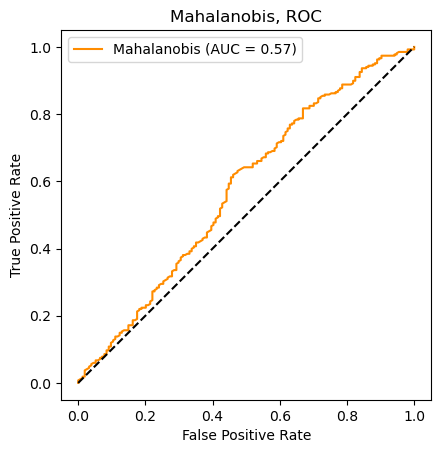

In [214]:
# ROC curve

print(x_test.shape)
print(x_ood.shape)
XX = np.concatenate((x_test,x_ood), axis=0)
print(XX.shape)

yy = [0]*x_test.shape[0] + [1]*x_ood.shape[0]      # 0 - ID, 1 - OOD


import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mahalanobis, ROC")
plt.legend()
plt.show()